In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

C:\Python34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
gameTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedGameData.csv')
dvoaTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedDvoaData.csv', encoding='windows-1252')
pffTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedPffData.csv')

In [3]:
# First, turn date cols into dt objects
gameTable['date'] = pd.to_datetime(gameTable['date'])
pffTable['date'] = pd.to_datetime(pffTable['date'])

In [4]:
# Create a table of running averages for pff grades and game scores. Use previous 7-game averages for a team's variables
rollAvgPff = pffTable.set_index('date')
varDict = {'pf':'avgPf','pa':'avgPa','overall':'avgOvr','off':'avgOff','pass':'avgPass','pblk':'avgPblk','recv':'avgRecv',
           'run':'avgRun','rblk':'avgRblk','def':'avgDef','rdef':'avgRdef','tack':'avgTack','prsh':'avgPrsh','cov':'avgCov'}

for key, val in varDict.items():
    rollAvgPff[val] = rollAvgPff.groupby('team')[key].apply(lambda x: x.shift(1).rolling(window=7).mean())

rollAvgPff = rollAvgPff.fillna(method='bfill')
rollAvgPff = rollAvgPff.reset_index()

In [5]:
# Need to make new rollingAvgPff tables that have all dates covered... Dates in pff table are off by one or two days
# Strategy is to create new df's that have all dates, then join the normal pff table to each of them by date,
# then merge all the tables together. All dates will be in the final table
pffB1 = rollAvgPff.copy()
pffB1['date'] = pffB1['date'] - datetime.timedelta(days=1)
pffB2 = rollAvgPff.copy()
pffB2['date'] = pffB2['date'] - datetime.timedelta(days=2)
pffF1 = rollAvgPff.copy()
pffF1['date'] = pffF1['date'] + datetime.timedelta(days=1)
pffF2 = rollAvgPff.copy()
pffF2['date'] = pffF2['date'] + datetime.timedelta(days=2)

In [6]:
# Now join pffTable to each new df
t0 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t1 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t2 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t3 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t4 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t5 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t6 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t7 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t8 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t9 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])

In [7]:
awayTable = t0.append([t1,t2,t3,t4],ignore_index=True)
homeTable = t5.append([t6,t7,t8,t9],ignore_index=True)

In [8]:
awayTable['homeAway'] = 'away'
homeTable['homeAway'] = 'home'

In [9]:
awayTable.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week', 'team', 'opp',
       'time', 'w', 'pf', 'pa', 'overall', 'off', 'pass', 'pblk', 'recv',
       'run', 'rblk', 'def', 'rdef', 'tack', 'prsh', 'cov', 'spec', 'lateGame',
       'year', 'avgPa', 'avgRun', 'avgRdef', 'avgTack', 'avgPrsh', 'avgOff',
       'avgPf', 'avgPass', 'avgPblk', 'avgRecv', 'avgOvr', 'avgDef', 'avgRblk',
       'avgCov', 'homeAway'],
      dtype='object')

In [10]:
awayTable = awayTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]
homeTable = homeTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]

In [11]:
awayTable.head()

,gameId,date,season,week,team,homeAway,stadium,roof,surface,avgPf,...,avgRblk,avgDef,avgRdef,avgPrsh,avgCov,pf,pa,totalScore,overUnder,result
0,201811110kan,2018-11-11,2018,10,Arizona Cardinals,away,Arrowhead Stadium,outdoors,grass,14.857143,...,55.657143,66.342857,64.657143,64.000000,65.514286,14,26,40,49.5,under
1,201610300car,2016-10-30,2016,8,Arizona Cardinals,away,Bank of America Stadium,outdoors,grass,22.714286,...,69.985714,73.785714,70.371429,71.000000,68.414286,20,30,50,45.5,over
2,201612240sea,2016-12-24,2016,16,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,25.857143,...,70.128571,64.900000,63.871429,65.057143,61.528571,34,31,65,43.5,over
3,201812300sea,2018-12-30,2018,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,13.000000,...,60.071429,61.785714,62.857143,62.057143,59.971429,24,27,51,39.5,over
4,201712310sea,2017-12-31,2017,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,18.571429,...,57.585714,73.028571,77.542857,67.028571,66.442857,26,24,50,38.0,over


In [12]:
# Transform week from dvoa table into correct format for analysis (add one)
dvoaTable['week'] = dvoaTable['week'] + 1

In [13]:
# Next, join these tables with DVOA table
awayTable = awayTable.merge(dvoaTable, on=['season','week','team'])
homeTable = homeTable.merge(dvoaTable, on=['season','week','team'])

In [14]:
%store awayTable
%store homeTable
%store gameTable
awayTable.columns

Stored 'awayTable' (DataFrame)
Stored 'homeTable' (DataFrame)
Stored 'gameTable' (DataFrame)


Index(['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'pf', 'pa', 'totalScore', 'overUnder', 'result',
       'totalDvoa', 'offDvoa', 'offRank', 'defDvoa', 'defRank', 'stDvoa',
       'stRank'],
      dtype='object')

In [15]:
# We only want the team's offensive and total grade columns and the team's opponent's
# defensive/total grade cols
# We can make two copies of both tables: awayOff, awayDef, homeOff, homeDef. Then join
# awayOff with homeDef, and join homeOff with awayDef and predict team totals for each game
# after transforming variables by combining columns.
awayOff = awayTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
awayDef = awayTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]
homeOff = homeTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
homeDef = homeTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]


In [16]:
homeDef # Now we need to join awayOff w/ homeDef, and homeOff w/awayDef. THEN we can predict implied totals

,gameId,date,season,week,team,stadium,roof,surface,avgPa,avgOvr,avgDef,avgRdef,avgPrsh,avgCov,totalDvoa,defDvoa,totalScore
0,201811110kan,2018-11-11,2018,10,Kansas City Chiefs,Arrowhead Stadium,outdoors,grass,23.000000,77.185714,69.142857,58.228571,73.685714,68.057143,0.438,0.076,40
1,201610300car,2016-10-30,2016,8,Carolina Panthers,Bank of America Stadium,outdoors,grass,28.571429,69.371429,67.071429,66.857143,66.200000,63.071429,-0.093,0.031,50
2,201612240sea,2016-12-24,2016,16,Seattle Seahawks,CenturyLink Field,outdoors,turf,18.000000,71.157143,68.700000,71.157143,64.114286,64.685714,0.100,-0.128,65
3,201812300sea,2018-12-30,2018,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,23.857143,73.585714,66.014286,67.885714,63.100000,61.857143,0.084,0.010,51
4,201712310sea,2017-12-31,2017,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,22.428571,68.742857,68.442857,65.357143,67.928571,68.700000,0.024,-0.052,50
5,201712170was,2017-12-17,2017,15,Washington Redskins,FedExField,outdoors,grass,28.142857,64.500000,62.942857,59.457143,65.928571,61.542857,-0.040,-0.031,35
6,201709100det,2017-09-10,2017,1,Detroit Lions,Ford Field,dome,turf,22.714286,68.928571,63.200000,62.542857,59.271429,61.771429,0.016,0.006,58
7,201611270atl,2016-11-27,2016,12,Atlanta Falcons,Georgia Dome,dome,turf,27.428571,76.857143,66.528571,68.657143,65.671429,62.885714,0.189,0.086,57
8,201612110mia,2016-12-11,2016,14,Miami Dolphins,Hard Rock Stadium,outdoors,grass,22.714286,72.285714,68.600000,66.271429,69.085714,65.685714,-0.004,0.000,49
9,201812020gnb,2018-12-02,2018,13,Green Bay Packers,Lambeau Field,outdoors,grass,26.285714,73.471429,65.985714,65.685714,68.271429,61.300000,0.115,0.016,37


In [17]:
awayMatchup = awayOff.merge(homeDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
homeMatchup = homeOff.merge(awayDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
#awayMatchup.columns

In [18]:
homeMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa'],
      dtype='object')

In [19]:
# Now we will create new columns for these two tables by combining matchups
# Ex) add awayMatchup['avgOff'] + awayMatchup['avgDef'] ('avgDef' is the away team's opponent's average defensive grade)
# to turn these two columns into one

awayMatchup['ptsMatchup'] = awayMatchup['avgPf'] + awayMatchup['avgPa']
awayMatchup['offMatchup'] = awayMatchup['avgOff'] - awayMatchup['avgDef']
awayMatchup['ovrMatchup'] = awayMatchup['avgOvr_x'] - awayMatchup['avgOvr_y']
awayMatchup['passMatchup'] = awayMatchup['avgPass'] - awayMatchup['avgCov']
awayMatchup['pblkMatchup'] = awayMatchup['avgPblk'] - awayMatchup['avgPrsh']
awayMatchup['runMatchup'] = awayMatchup['avgRun'] - awayMatchup['avgRdef']
awayMatchup['offDvoaMatchup'] = awayMatchup['offDvoa'] - awayMatchup['defDvoa']
awayMatchup['totalDvoaMatchup'] = awayMatchup['totalDvoa_x'] - awayMatchup['totalDvoa_y']

In [20]:
homeMatchup['ptsMatchup'] = homeMatchup['avgPf'] + homeMatchup['avgPa']
homeMatchup['offMatchup'] = homeMatchup['avgOff'] - homeMatchup['avgDef']
homeMatchup['ovrMatchup'] = homeMatchup['avgOvr_x'] - homeMatchup['avgOvr_y']
homeMatchup['passMatchup'] = homeMatchup['avgPass'] - homeMatchup['avgCov']
homeMatchup['pblkMatchup'] = homeMatchup['avgPblk'] - homeMatchup['avgPrsh']
homeMatchup['runMatchup'] = homeMatchup['avgRun'] - homeMatchup['avgRdef']
homeMatchup['offDvoaMatchup'] = homeMatchup['offDvoa'] - homeMatchup['defDvoa']
homeMatchup['totalDvoaMatchup'] = homeMatchup['totalDvoa_x'] - homeMatchup['totalDvoa_y']

In [21]:
cols = list(awayMatchup.columns)
cols
cols.pop(21)
cols.append('pf')


In [22]:
awayMatchup = awayMatchup[cols]
homeMatchup = homeMatchup[cols]

In [23]:
%store awayMatchup
%store homeMatchup

Stored 'awayMatchup' (DataFrame)
Stored 'homeMatchup' (DataFrame)


In [24]:
# Only use weeks > 3 since dvoa is inaccurate before week 3, typically
awayMatchup = awayMatchup[awayMatchup['week'] >= 3]
homeMatchup = homeMatchup[homeMatchup['week'] >= 3]

In [25]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(awayMatchup.iloc[:,:-1],awayMatchup.iloc[:,-1:], test_size=0.2,random_state=155)

In [26]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['pf']
cat_cols = ['roof','surface']
num_cols= ['ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
           'runMatchup', 'totalDvoaMatchup', 'offDvoaMatchup']
other_col= ['date','season','week','stadium','team_x','team_y','homeAway','avgPf',
            'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk','avgRun', 'avgRblk',
            'totalDvoa_x', 'offDvoa','pa', 'totalScore','avgPa', 'avgOvr_y',
            'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa','avgRecv','overUnder']

In [27]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train_away[var] = number.fit_transform(X_train_away[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_away[var] = number.fit_transform(X_test_away[var].astype('str'))

In [28]:
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

In [29]:
%store features

Stored 'features' (list)


In [30]:
X_train_away = X_train_away[list(features)]
X_test_away= X_test_away[list(features)]

In [31]:
X_train_away = X_train_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_away = X_test_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [32]:
X_train_away.head()

,stDvoa,runMatchup,ptsMatchup,offDvoaMatchup,offMatchup,ovrMatchup,passMatchup,surface,pblkMatchup,roof,totalDvoaMatchup
547,0.040,-7.128571,40.714286,0.028,-0.985714,-6.671429,-2.657143,1,5.600000,0,-0.108
2082,0.037,-6.214286,49.000000,-0.173,4.585714,-3.500000,3.885714,0,7.942857,1,-0.256
1463,0.059,0.785714,48.857143,-0.408,9.842857,11.914286,3.528571,0,10.728571,1,0.187
297,-0.070,-17.457143,30.285714,-0.130,-13.100000,-13.128571,-12.785714,1,3.828571,1,-0.497
1092,-0.107,-3.500000,48.571429,-0.699,6.185714,0.400000,-0.871429,1,9.428571,0,-0.861


In [33]:
# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_away, y_train_away)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_away, y_train_away, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.07595241  0.12035641  0.05608436  0.08766145  0.10561538  0.04818738
  0.08712081  0.12690538  0.18216364  0.15537197]


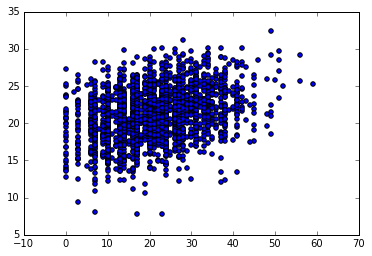

In [35]:
predictions = cross_val_predict(regressor, X_train_away, y_train_away, cv=10)
plt.scatter(y_train_away, predictions)
plt.show()

In [36]:
accuracy = metrics.r2_score(y_train_away, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.109532669811


In [37]:
#Add column of ones to account for b_0
X_train_away = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_away, axis = 1)
X_train_away[1]

array([  1.00000000e+00,   3.70000000e-02,  -6.21428571e+00,
         4.90000000e+01,  -1.73000000e-01,   4.58571429e+00,
        -3.50000000e+00,   3.88571429e+00,   0.00000000e+00,
         7.94285714e+00,   1.00000000e+00,  -2.56000000e-01])

In [38]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     27.12
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.34e-53
Time:                        17:33:26   Log-Likelihood:                -7969.3
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2176   BIC:                         1.603e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6099      1.995      6.320      0.000       8.697      16.523
x1            -2.3324      4.080     -0.572      0.568     -10.333       5.668
x2             0.0540      0.040      1.347      0.178      -0.025       0.133
x3             0.2019      0.044      4.612      0.000       0.116       0.288
x4             2.8790      0.970      2.969      0.003       0.978       4.780
x5            -0.0124      0.075     -0.166      0.868      -0.159       0.134
x6            -0.0966      0.056     -1.740      0.082      -0.206       0.012
x7             0.1219      0.047      2.597      0.009       0.030       0.214
x8            -0.3760      0.453     -0.830      0.407      -1.264       0.512
x9            -0.0484      0.031     -1.577      0.115      -0.108       0.012
x10           -0.2184      0.511     -0.427      0.669      -1.221       0.784
x11            5.9163      0.935      6.328      0.000       4.083       7.750
==============================================================================
Omnibus:                       15.127   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.330
Skew:                           0.205   Prob(JB):                     0.000469
Kurtosis:                       2.998   Cond. No.                         965.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
X_opt = X_train_away[:, [0,1,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     29.84
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           2.42e-54
Time:                        17:33:27   Log-Likelihood:                -7969.3
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2177   BIC:                         1.602e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6131      1.995      6.323      0.000       8.701      16.525
x1            -2.3117      4.077     -0.567      0.571     -10.307       5.684
x2             0.0494      0.029      1.710      0.087      -0.007       0.106
x3             0.2009      0.043      4.634      0.000       0.116       0.286
x4             2.8812      0.969      2.972      0.003       0.980       4.782
x5            -0.0991      0.053     -1.853      0.064      -0.204       0.006
x6             0.1162      0.032      3.638      0.000       0.054       0.179
x7            -0.3757      0.453     -0.830      0.407      -1.264       0.512
x8            -0.0508      0.027     -1.894      0.058      -0.103       0.002
x9            -0.2154      0.511     -0.422      0.673      -1.217       0.786
x10            5.9334      0.929      6.386      0.000       4.111       7.755
==============================================================================
Omnibus:                       15.138   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.341
Skew:                           0.205   Prob(JB):                     0.000466
Kurtosis:                       2.998   Cond. No.                         959.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
X_opt = X_train_away[:, [0,1,2,3,4,6,7,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     33.15
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           4.44e-55
Time:                        17:33:27   Log-Likelihood:                -7969.4
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2178   BIC:                         1.602e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4250      1.944      6.392      0.000       8.613      16.237
x1            -2.3032      4.076     -0.565      0.572     -10.297       5.690
x2             0.0512      0.029      1.789      0.074      -0.005       0.107
x3             0.2009      0.043      4.636      0.000       0.116       0.286
x4             2.8495      0.966      2.949      0.003       0.955       4.744
x5            -0.1006      0.053     -1.885      0.060      -0.205       0.004
x6             0.1168      0.032      3.663      0.000       0.054       0.179
x7            -0.2878      0.402     -0.716      0.474      -1.076       0.501
x8            -0.0514      0.027     -1.919      0.055      -0.104       0.001
x9             5.9638      0.926      6.440      0.000       4.148       7.780
==============================================================================
Omnibus:                       14.918   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.118
Skew:                           0.204   Prob(JB):                     0.000521
Kurtosis:                       2.996   Cond. No.                         959.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
X_opt = X_train_away[:, [0,2,3,4,6,7,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     37.26
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           8.22e-56
Time:                        17:33:27   Log-Likelihood:                -7969.5
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2179   BIC:                         1.601e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4857      1.941      6.434      0.000       8.680      16.291
x1             0.0517      0.029      1.809      0.071      -0.004       0.108
x2             0.1995      0.043      4.611      0.000       0.115       0.284
x3             2.8356      0.966      2.936      0.003       0.942       4.730
x4            -0.0980      0.053     -1.844      0.065      -0.202       0.006
x5             0.1176      0.032      3.690      0.000       0.055       0.180
x6            -0.2856      0.402     -0.711      0.477      -1.074       0.503
x7            -0.0511      0.027     -1.909      0.056      -0.104       0.001
x8             5.8824      0.915      6.431      0.000       4.089       7.676
==============================================================================
Omnibus:                       14.801   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.003
Skew:                           0.203   Prob(JB):                     0.000552
Kurtosis:                       2.992   Cond. No.                         461.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
X_opt = X_train_away[:, [0,2,3,4,6,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     42.52
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.55e-56
Time:                        17:33:28   Log-Likelihood:                -7969.8
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2180   BIC:                         1.600e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4030      1.937      6.404      0.000       8.605      16.201
x1             0.0531      0.029      1.864      0.062      -0.003       0.109
x2             0.1988      0.043      4.597      0.000       0.114       0.284
x3             2.8714      0.964      2.978      0.003       0.980       4.763
x4            -0.0950      0.053     -1.792      0.073      -0.199       0.009
x5             0.1170      0.032      3.675      0.000       0.055       0.179
x6            -0.0520      0.027     -1.946      0.052      -0.105       0.000
x7             5.8541      0.914      6.407      0.000       4.062       7.646
==============================================================================
Omnibus:                       14.805   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.005
Skew:                           0.203   Prob(JB):                     0.000552
Kurtosis:                       2.993   Cond. No.                         460.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
X_opt = X_train_away[:, [0,2,3,4,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     49.03
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.03e-56
Time:                        17:33:28   Log-Likelihood:                -7971.4
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2181   BIC:                         1.600e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7857      1.926      6.638      0.000       9.009      16.563
x1             0.0407      0.028      1.471      0.141      -0.014       0.095
x2             0.1920      0.043      4.455      0.000       0.107       0.277
x3             2.7911      0.964      2.896      0.004       0.901       4.681
x4             0.0957      0.030      3.238      0.001       0.038       0.154
x5            -0.0617      0.026     -2.355      0.019      -0.113      -0.010
x6             5.0318      0.791      6.365      0.000       3.481       6.582
==============================================================================
Omnibus:                       14.422   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.617
Skew:                           0.200   Prob(JB):                     0.000670
Kurtosis:                       2.987   Cond. No.                         459.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
X_opt = X_train_away[:, [0,3,4,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     58.37
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           3.70e-57
Time:                        17:33:29   Log-Likelihood:                -7972.5
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2182   BIC:                         1.599e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0907      1.868      6.474      0.000       8.428      15.753
x1             0.2041      0.042      4.824      0.000       0.121       0.287
x2             2.6080      0.956      2.728      0.006       0.733       4.483
x3             0.0948      0.030      3.206      0.001       0.037       0.153
x4            -0.0647      0.026     -2.476      0.013      -0.116      -0.013
x5             5.1250      0.788      6.502      0.000       3.579       6.671
==============================================================================
Omnibus:                       13.877   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.067
Skew:                           0.196   Prob(JB):                     0.000882
Kurtosis:                       2.979   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
X_opt = X_train_away[:, [0,3,4,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     58.37
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           3.70e-57
Time:                        17:33:29   Log-Likelihood:                -7972.5
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2182   BIC:                         1.599e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0907      1.868      6.474      0.000       8.428      15.753
x1             0.2041      0.042      4.824      0.000       0.121       0.287
x2             2.6080      0.956      2.728      0.006       0.733       4.483
x3             0.0948      0.030      3.206      0.001       0.037       0.153
x4            -0.0647      0.026     -2.476      0.013      -0.116      -0.013
x5             5.1250      0.788      6.502      0.000       3.579       6.671
==============================================================================
Omnibus:                       13.877   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.067
Skew:                           0.196   Prob(JB):                     0.000882
Kurtosis:                       2.979   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
X_opt = X_train_away[:, [0,3,4,7,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     71.26
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           8.49e-57
Time:                        17:33:34   Log-Likelihood:                -7975.5
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2183   BIC:                         1.599e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0417      1.870      6.440      0.000       8.375      15.708
x1             0.1948      0.042      4.616      0.000       0.112       0.277
x2             2.5658      0.957      2.681      0.007       0.689       4.442
x3             0.0993      0.030      3.361      0.001       0.041       0.157
x4             4.9566      0.786      6.304      0.000       3.415       6.498
==============================================================================
Omnibus:                       14.783   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.010
Skew:                           0.202   Prob(JB):                     0.000550
Kurtosis:                       2.973   Cond. No.                         439.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$y_{away} = 0.195x_{ptsMatchup} + 2.566x_{offDvoaMatchup} + 0.099x_{passMatchup} + 4.957x_{totalDvoaMatchup} + 12.042$

In [47]:
# Optimal model using alpha < 0.05 significance level ^
X_test_away.shape

(548, 11)

In [48]:
# Now use this model to make predictions on the test set
X_test_away = np.append(arr = np.ones((548,1)).astype(int), values = X_test_away, axis = 1)
X_test_away = X_test_away[:, [0,3,4,7,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_away)
y_pred_away = regressor.predict(X_test_away)

In [49]:
print(mean_squared_error(y_test_away, y_pred_away))

99.3727070223


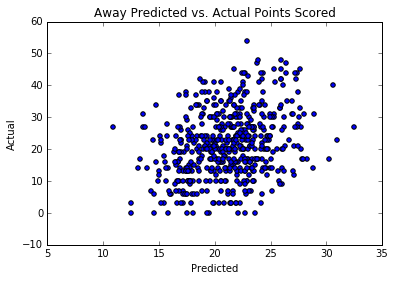

In [50]:
plt.scatter(y_pred_away, y_test_away)
plt.title("Away Predicted vs. Actual Points Scored")
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [51]:
from scipy.stats import pearsonr
pearsonr(y_test_away,y_pred_away)

(array([ 0.30686763]), array([  2.05552343e-13]))

We can see a pretty clear positive correlation between our predicted and actual values for away teams. The pearson correlation comes out as .349, with an extremely  low p-value

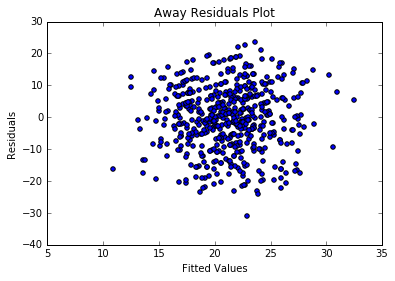

In [52]:
residuals = y_pred_away - y_test_away
plt.scatter(y_pred_away, residuals)
plt.title("Away Residuals Plot")
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. One thing to note is that the residuals tend to be a bit more negative than positive. One reason for this might be that it is much easier for an NFL team to not play well and heavily underperform than it is for a team to play so well that they outperform their prediction by 20+ points.

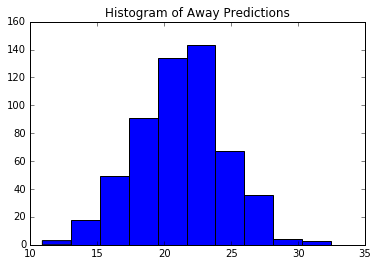

In [80]:
plt.hist(y_pred_away)
plt.title("Histogram of Away Predictions")
plt.show()

The histogram of our predictions is clearly normal, and centered around the 20-22 range. There may be one or two predictions above 30, but nothing out of the ordinary here.

In [54]:
import statsmodels.api as sm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline 

C:\Python34\Lib\importlib\_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


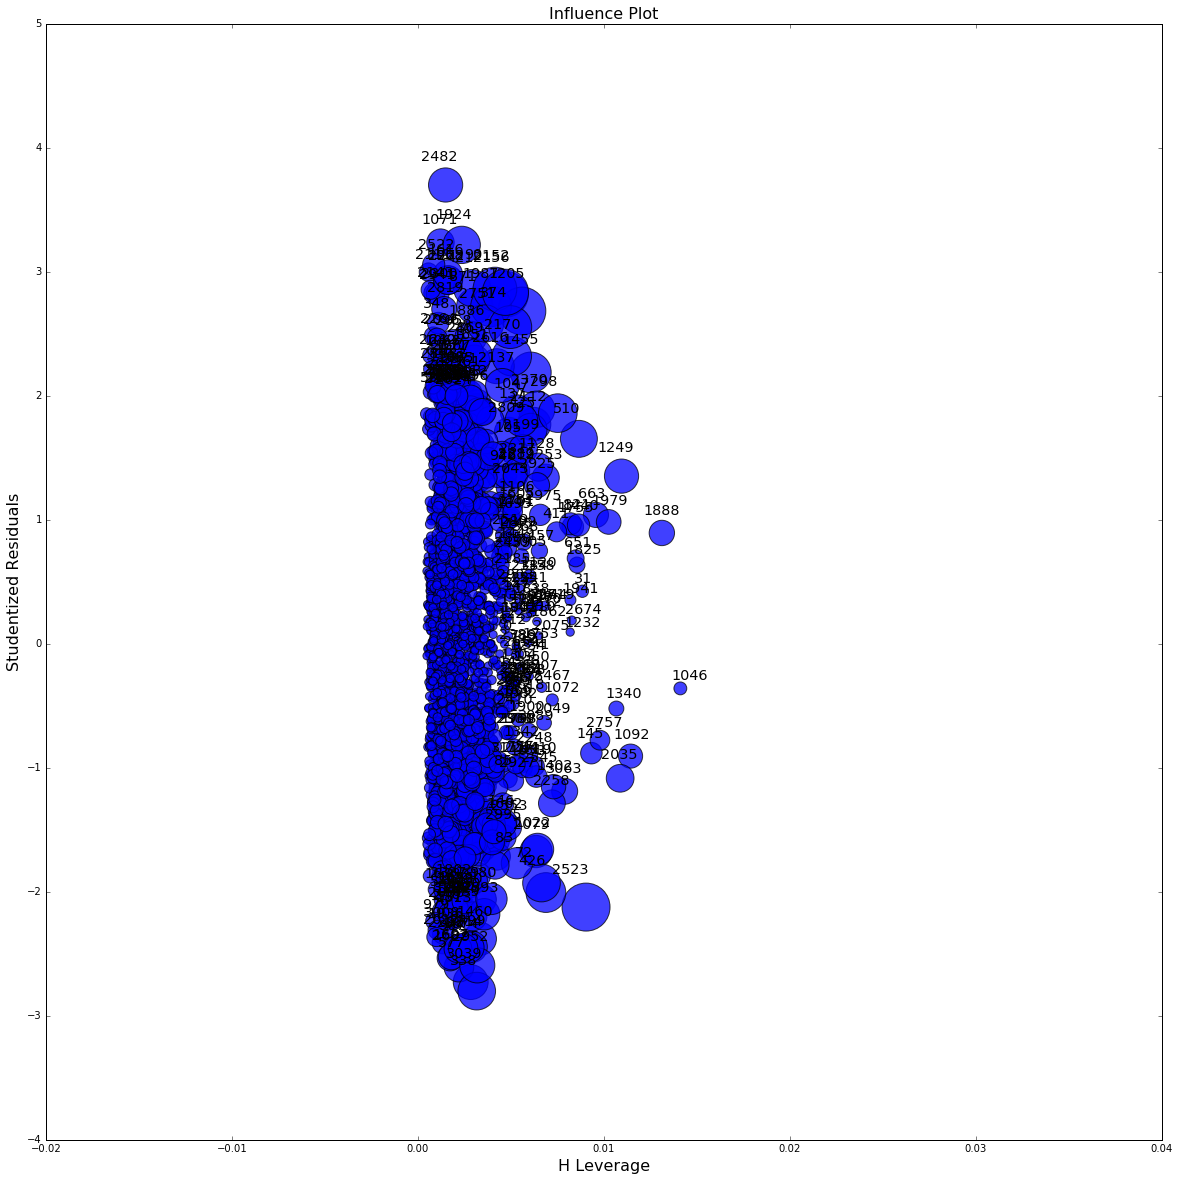

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the awayMatchup table. Let's move on to the home table.

In [58]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,random_state=155)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_home.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

X_train_home = X_train_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_home = X_test_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [59]:
X_train_home.head()

,stDvoa,runMatchup,ptsMatchup,offDvoaMatchup,offMatchup,ovrMatchup,passMatchup,surface,pblkMatchup,roof,totalDvoaMatchup
547,0.004,-2.985714,49.428571,0.016,8.928571,6.671429,10.885714,1,7.542857,0,0.108
2082,0.019,-3.800000,45.714286,0.075,9.942857,3.500000,12.014286,0,10.957143,1,0.256
1463,0.098,-14.542857,36.857143,0.286,-10.142857,-11.914286,-16.700000,0,4.800000,1,-0.187
297,0.031,-6.214286,46.714286,0.374,6.085714,13.128571,9.028571,1,16.385714,1,0.497
1092,0.016,8.028571,51.285714,0.300,8.042857,-0.400000,-3.585714,1,1.971429,0,0.861


In [60]:
regressor = LinearRegression()
regressor.fit(X_train_home, y_train_home)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_home, y_train_home, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.09526243  0.09354666  0.14701957  0.1424986   0.13255132  0.0350765
  0.13318823  0.09000204  0.1758974   0.0941878 ]


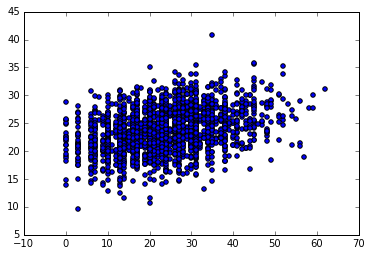

In [62]:
predictions = cross_val_predict(regressor, X_train_home, y_train_home, cv=10)
plt.scatter(y_train_home, predictions)
plt.show()

In [63]:
accuracy = metrics.r2_score(y_train_home, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.116331602125


In [64]:
X_train_home.shape

(2188, 11)

In [65]:
#Add column of ones to account for b_0
X_train_home = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_home, axis = 1)
X_train_home[1]

array([  1.00000000e+00,   1.90000000e-02,  -3.80000000e+00,
         4.57142857e+01,   7.50000000e-02,   9.94285714e+00,
         3.50000000e+00,   1.20142857e+01,   0.00000000e+00,
         1.09571429e+01,   1.00000000e+00,   2.56000000e-01])

In [66]:
X_opt = X_train_home[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     28.56
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.58e-56
Time:                        17:37:07   Log-Likelihood:                -8114.2
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2176   BIC:                         1.632e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9382      2.164      5.979      0.000       8.694      17.182
x1             4.0049      4.381      0.914      0.361      -4.586      12.596
x2             0.0338      0.042      0.803      0.422      -0.049       0.116
x3             0.2408      0.047      5.151      0.000       0.149       0.332
x4             5.7885      1.021      5.667      0.000       3.785       7.792
x5             0.0292      0.080      0.366      0.715      -0.127       0.186
x6            -0.0744      0.059     -1.269      0.205      -0.189       0.041
x7             0.0466      0.050      0.942      0.346      -0.050       0.144
x8             0.6674      0.487      1.370      0.171      -0.288       1.623
x9             0.0754      0.034      2.240      0.025       0.009       0.141
x10           -1.2484      0.543     -2.297      0.022      -2.314      -0.183
x11            5.0588      1.008      5.021      0.000       3.083       7.035
==============================================================================
Omnibus:                       24.907   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.467
Skew:                           0.256   Prob(JB):                     2.95e-06
Kurtosis:                       3.132   Cond. No.                         968.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     31.41
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           2.93e-57
Time:                        17:37:07   Log-Likelihood:                -8114.3
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2177   BIC:                         1.631e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9571      2.163      5.990      0.000       8.715      17.199
x1             3.9111      4.372      0.895      0.371      -4.663      12.486
x2             0.0448      0.029      1.519      0.129      -0.013       0.103
x3             0.2427      0.046      5.226      0.000       0.152       0.334
x4             5.7917      1.021      5.671      0.000       3.789       7.794
x5            -0.0692      0.057     -1.217      0.224      -0.181       0.042
x6             0.0599      0.034      1.774      0.076      -0.006       0.126
x7             0.6571      0.486      1.351      0.177      -0.296       1.611
x8             0.0815      0.029      2.788      0.005       0.024       0.139
x9            -1.2624      0.542     -2.330      0.020      -2.325      -0.200
x10            5.0281      1.004      5.008      0.000       3.059       6.997
==============================================================================
Omnibus:                       24.909   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.469
Skew:                           0.256   Prob(JB):                     2.95e-06
Kurtosis:                       3.131   Cond. No.                         961.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
X_opt = X_train_home[:, [0,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     34.82
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           7.12e-58
Time:                        17:37:07   Log-Likelihood:                -8114.7
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2178   BIC:                         1.631e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7781      2.154      5.933      0.000       8.555      17.002
x1             0.0454      0.029      1.542      0.123      -0.012       0.103
x2             0.2454      0.046      5.296      0.000       0.155       0.336
x3             5.8398      1.020      5.727      0.000       3.840       7.840
x4            -0.0755      0.056     -1.336      0.182      -0.186       0.035
x5             0.0590      0.034      1.749      0.080      -0.007       0.125
x6             0.7235      0.481      1.506      0.132      -0.219       1.666
x7             0.0808      0.029      2.766      0.006       0.024       0.138
x8            -1.2154      0.539     -2.254      0.024      -2.273      -0.158
x9             5.2026      0.985      5.283      0.000       3.271       7.134
==============================================================================
Omnibus:                       25.348   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.929
Skew:                           0.259   Prob(JB):                     2.34e-06
Kurtosis:                       3.128   Cond. No.                         478.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
X_opt = X_train_home[:, [0,2,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     38.93
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           2.64e-58
Time:                        17:37:08   Log-Likelihood:                -8115.6
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2179   BIC:                         1.630e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1872      2.132      6.185      0.000       9.006      17.369
x1             0.0359      0.029      1.256      0.209      -0.020       0.092
x2             0.2381      0.046      5.173      0.000       0.148       0.328
x3             5.8345      1.020      5.720      0.000       3.834       7.835
x4             0.0433      0.032      1.370      0.171      -0.019       0.105
x5             0.6862      0.480      1.430      0.153      -0.255       1.627
x6             0.0724      0.029      2.537      0.011       0.016       0.128
x7            -1.2135      0.539     -2.250      0.025      -2.271      -0.156
x8             4.5453      0.853      5.327      0.000       2.872       6.218
==============================================================================
Omnibus:                       25.261   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.831
Skew:                           0.259   Prob(JB):                     2.46e-06
Kurtosis:                       3.122   Cond. No.                         476.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
X_opt = X_train_home[:, [0,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     44.26
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           8.25e-59
Time:                        17:37:08   Log-Likelihood:                -8116.4
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2180   BIC:                         1.629e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5193      2.065      6.062      0.000       8.470      16.569
x1             0.2505      0.045      5.572      0.000       0.162       0.339
x2             5.6646      1.011      5.603      0.000       3.682       7.647
x3             0.0417      0.032      1.318      0.188      -0.020       0.104
x4             0.6813      0.480      1.420      0.156      -0.260       1.622
x5             0.0703      0.028      2.468      0.014       0.014       0.126
x6            -1.2380      0.539     -2.296      0.022      -2.295      -0.181
x7             4.6083      0.852      5.410      0.000       2.938       6.279
==============================================================================
Omnibus:                       26.842   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.519
Skew:                           0.266   Prob(JB):                     1.06e-06
Kurtosis:                       3.134   Cond. No.                         461.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
X_opt = X_train_home[:, [0,3,4,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     51.33
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           2.59e-59
Time:                        17:37:08   Log-Likelihood:                -8117.3
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2181   BIC:                         1.629e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3455      1.863      6.089      0.000       7.691      15.000
x1             0.2798      0.039      7.155      0.000       0.203       0.356
x2             5.8236      1.004      5.800      0.000       3.855       7.793
x3             0.6962      0.480      1.451      0.147      -0.245       1.637
x4             0.0684      0.028      2.403      0.016       0.013       0.124
x5            -1.2646      0.539     -2.347      0.019      -2.321      -0.208
x6             4.7749      0.843      5.667      0.000       3.123       6.427
==============================================================================
Omnibus:                       26.306   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.941
Skew:                           0.265   Prob(JB):                     1.41e-06
Kurtosis:                       3.125   Cond. No.                         423.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
X_opt = X_train_home[:, [0,3,4,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     61.14
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           8.86e-60
Time:                        17:37:09   Log-Likelihood:                -8118.3
No. Observations:                2188   AIC:                         1.625e+04
Df Residuals:                    2182   BIC:                         1.628e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9189      1.821      6.544      0.000       8.347      15.491
x1             0.2793      0.039      7.141      0.000       0.203       0.356
x2             5.9439      1.001      5.939      0.000       3.981       7.907
x3             0.0706      0.028      2.484      0.013       0.015       0.126
x4            -1.6173      0.481     -3.362      0.001      -2.561      -0.674
x5             4.8045      0.842      5.703      0.000       3.152       6.457
==============================================================================
Omnibus:                       25.937   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.548
Skew:                           0.263   Prob(JB):                     1.72e-06
Kurtosis:                       3.122   Cond. No.                         413.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
X_test_home.shape

(548, 11)

In [74]:
# Now use this model to make predictions on the test set
X_test_home = np.append(arr = np.ones((548,1)).astype(int), values = X_test_home, axis = 1)
X_test_home = X_test_home[:, [0,3,4,9,10,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_home)
y_pred_home = regressor.predict(X_test_home)

In [75]:
print(mean_squared_error(y_test_home, y_pred_home))

100.915501367


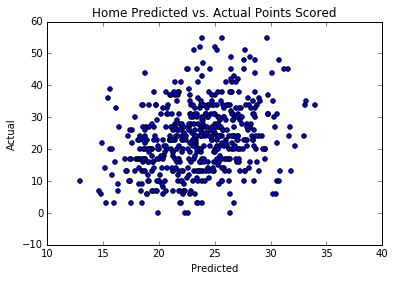

In [76]:
plt.scatter(y_pred_home, y_test_home)
plt.title("Home Predicted vs. Actual Points Scored")
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [77]:
from scipy.stats import pearsonr
pearsonr(y_test_home,y_pred_home)

(array([ 0.30586914]), array([  2.47935457e-13]))

We can see a pretty clear positive correlation between our predicted and actual values for home teams. The pearson correlation comes out as .311, with an extremely  low p-value

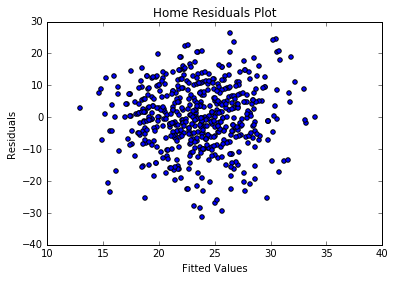

In [79]:
residuals = y_pred_home - y_test_home
plt.scatter(y_pred_home, residuals)
plt.title('Home Residuals Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. We may want to explore the three points to the left.

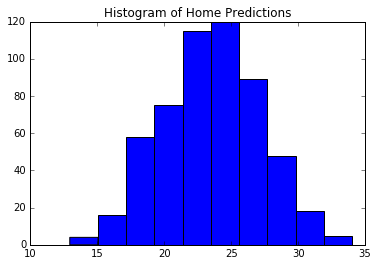

In [81]:
plt.hist(y_pred_home)
plt.title("Histogram of Home Predictions")
plt.show()

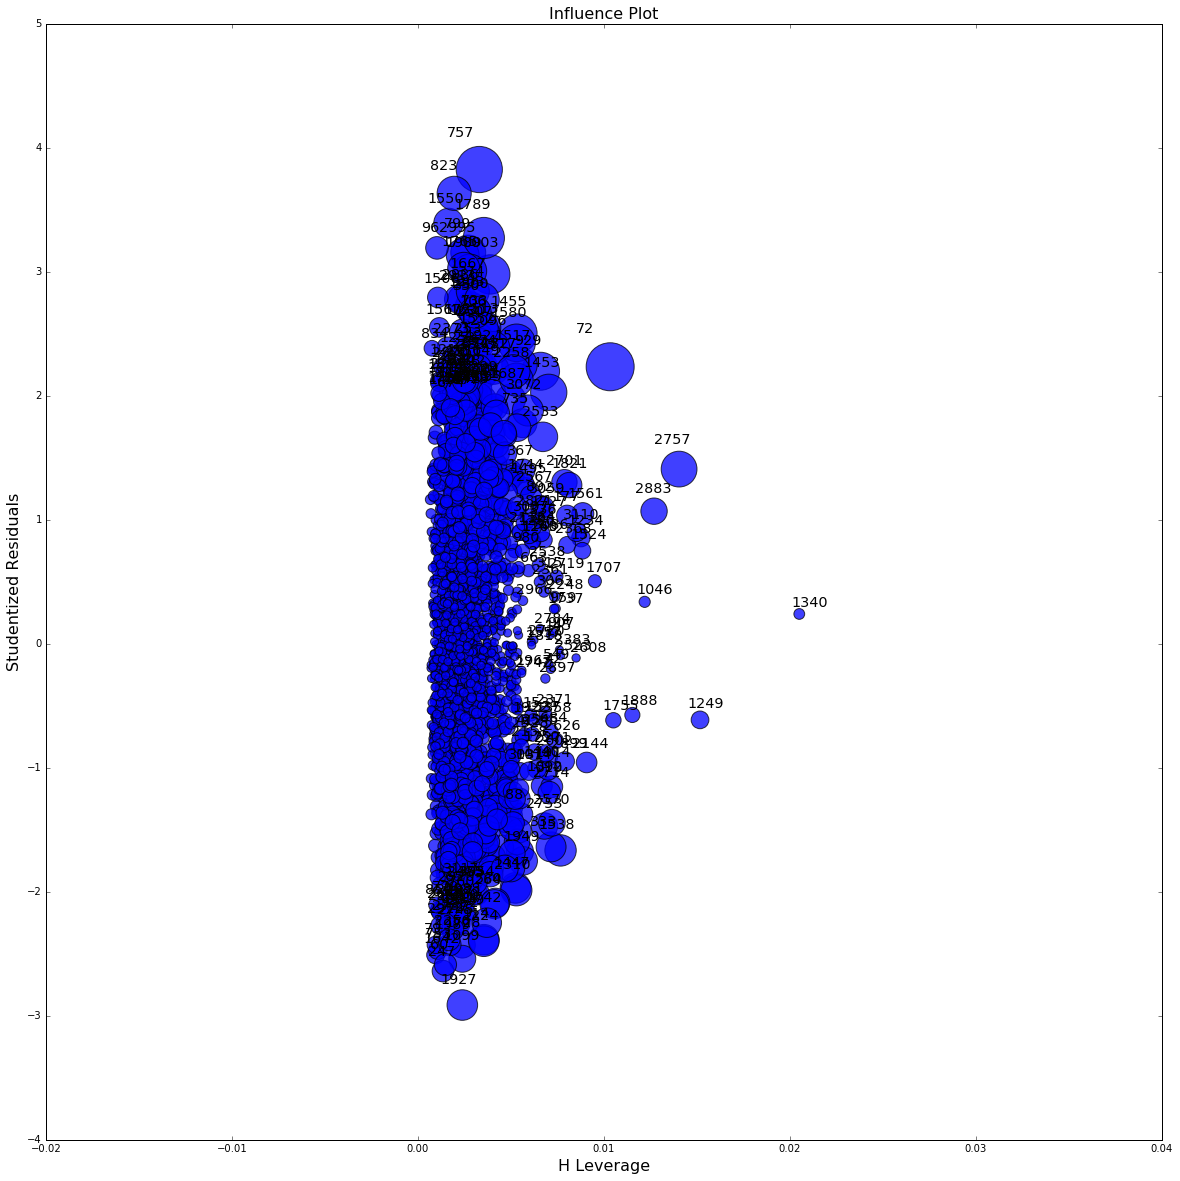

In [83]:
fig, ax = plt.subplots(figsize=(20,20))
fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the homeMatchup table. Now let's put it all together and make predictions for total scores between home and away teams.

In [2203]:
y_test_away = y_test_away.reset_index()
y_test_away = y_test_away[['pf']]
y_test_home = y_test_home.reset_index()
y_test_home = y_test_home[['pf']]

In [2204]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [2205]:
testDf = testDf.rename(index=int, columns = {1:'ptsMatchup',2:'offDvoaMatchup',3:'passMatchup',4:'totalDvoaMatchup'})
testDf = testDf.drop(0,axis=1)
testDf.head()

,ptsMatchup,offDvoaMatchup,passMatchup,totalDvoaMatchup,awayScore,awayPrediction
0,41.142857,-0.347,-2.000000,-0.161,22,18.167599
1,41.857143,-0.291,3.428571,-0.133,21,19.128068
2,43.857143,-0.016,5.657143,-0.103,7,20.593108
3,42.285714,0.090,0.985714,-0.215,21,19.540177
4,25.000000,-0.198,-10.471429,-0.574,0,12.517967


In [2206]:
testDf2.head()

,0,1,2,3,4,5,homeScore,homePrediction
0,1.0,46.714286,0.018,3.042857,0.0,0.161,17,26.061269
1,1.0,47.142857,0.218,15.714286,0.0,0.133,49,28.129435
2,1.0,48.857143,0.146,11.500000,1.0,0.103,21,26.121463
3,1.0,50.714286,0.000,22.428571,1.0,0.215,42,27.081670
4,1.0,41.142857,0.100,4.314286,1.0,0.574,27,25.449293


In [2207]:
testDf2 = testDf2.rename(index=int, columns = {1:'ptsMatchup',2:'offDvoaMatchup', 3: 'pblkMatchup',4:'roof',5:'totalDvoaMatchup'})
testDf2 = testDf2.drop(0,axis=1)
testDf2.head()

,ptsMatchup,offDvoaMatchup,pblkMatchup,roof,totalDvoaMatchup,homeScore,homePrediction
0,46.714286,0.018,3.042857,0.0,0.161,17,26.061269
1,47.142857,0.218,15.714286,0.0,0.133,49,28.129435
2,48.857143,0.146,11.500000,1.0,0.103,21,26.121463
3,50.714286,0.000,22.428571,1.0,0.215,42,27.081670
4,41.142857,0.100,4.314286,1.0,0.574,27,25.449293


In [2208]:
# Join awayMatchup table with away predictions and do same for home team. make sure to take out surface column
# since it is now binary, and wasn't in theoriginal table

colsAway = list(testDf.columns)
colsAway.pop(-1)
colsAway.pop(-1)
# colsAway
colsHome = list(testDf2.columns)
colsHome.pop(-1)
colsHome.pop(-1)
colsHome.pop(3)
# colsHome
# # cols.pop(7)
# # cols.pop(7)

'roof'

In [2209]:
awayPredDf = awayMatchup.merge(testDf, on=colsAway)
homePredDf = homeMatchup.merge(testDf2, on=colsHome)

In [2210]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
#awayHomeMerge.columns

In [2211]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201711050sfo,2017-11-05,2017,9,21.004974,22.024952
1,201701010ram,2017-01-01,2016,17,24.307527,20.335874
2,201610160sea,2016-10-16,2016,6,21.935420,23.210699
3,201812090gnb,2018-12-09,2018,14,21.721725,24.947507
4,201801060ram,2018-01-06,2017,18,20.536367,24.853592


In [2212]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
#finalDf.columns

In [2213]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [2214]:
finalDf.head()

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,200911220ram,2009-11-22,2009,11,Arizona Cardinals,27.450878,21,Los Angeles Rams,18.736524,13,47.0,under,46.187402,34
1,201210040ram,2012-10-04,2012,5,Arizona Cardinals,20.426009,3,Los Angeles Rams,19.998338,17,38.0,under,40.424347,20
2,200710210was,2007-10-21,2007,7,Arizona Cardinals,19.753134,19,Washington Redskins,24.075962,21,36.0,over,43.829095,40
3,201211180atl,2012-11-18,2012,11,Arizona Cardinals,16.937917,19,Atlanta Falcons,27.013741,23,44.0,under,43.951658,42
4,201510180pit,2015-10-18,2015,6,Arizona Cardinals,26.178861,13,Pittsburgh Steelers,25.033003,25,45.0,under,51.211864,38


In [2215]:
# What happens when our predictions are 5+ points less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 5]
undersDf['result'].value_counts()

under    14
over      8
Name: result, dtype: int64

In [2216]:
# What happens when our predictions are 3+ points less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 3]
undersDf['result'].value_counts()

under    34
over     27
Name: result, dtype: int64

In [2217]:
# What happens when our predictions are 1+ point less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf['result'].value_counts()

under    89
over     75
Name: result, dtype: int64

In [2218]:
# What happens when our predictions are 5+ points more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 5]
oversDf['result'].value_counts()

over     28
under    16
Name: result, dtype: int64

In [2219]:
# What happens when our predictions are 3+ points more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf['result'].value_counts()

over     65
under    42
Name: result, dtype: int64

In [2220]:
# What happens when our predictions are 1+ point more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 1]
oversDf['result'].value_counts()

over     124
under    109
push       3
Name: result, dtype: int64

We observe a 21-11 win/loss rate (65.625% win) when using the predictions that are 5+ points over the overUnder value. We get a 14-9 win/loss rate (60.87% win) when using the predictions that are 5+ points under the overUnder value. Both of these win rates exceed the needed win rate of 52.4% to beat the sports books.

In [2221]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 5]
oversDf

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
2,200710210was,2007-10-21,2007,7,Arizona Cardinals,19.753134,19,Washington Redskins,24.075962,21,36.0,over,43.829095,40
4,201510180pit,2015-10-18,2015,6,Arizona Cardinals,26.178861,13,Pittsburgh Steelers,25.033003,25,45.0,under,51.211864,38
6,201701010ram,2017-01-01,2016,17,Arizona Cardinals,24.307527,44,Los Angeles Rams,20.335874,6,39.0,over,44.643401,50
9,201509270dal,2015-09-27,2015,3,Atlanta Falcons,22.285779,39,Dallas Cowboys,28.253197,28,43.5,over,50.538975,67
23,201409210cle,2014-09-21,2014,3,Baltimore Ravens,21.277952,23,Cleveland Browns,26.797561,21,41.5,over,48.075513,44
28,200809290pit,2008-09-29,2008,4,Baltimore Ravens,22.569351,20,Pittsburgh Steelers,24.761447,23,34.5,over,47.330797,43
29,200901100oti,2009-01-10,2008,19,Baltimore Ravens,21.334446,13,Tennessee Titans,21.962668,10,33.5,under,43.297114,23
59,200711040oti,2007-11-04,2007,9,Carolina Panthers,17.122906,7,Tennessee Titans,23.647835,20,35.5,under,40.770741,27
80,201112250gnb,2011-12-25,2011,16,Chicago Bears,18.595247,21,Green Bay Packers,30.260589,35,42.0,over,48.855837,56
88,201201010min,2012-01-01,2011,17,Chicago Bears,24.239331,17,Minnesota Vikings,24.221782,13,42.0,under,48.461114,30
